In [1]:
!nvidia-smi

Wed Sep  8 10:56:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.116.00   Driver Version: 418.116.00   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:39:00.0 Off |                    0 |
| N/A   40C    P0    83W / 350W |     13MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# import the necessary packages

from imutils import paths
import imutils
import json
import time
import cv2
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

### Loading SpeakingFaces dataset

In [3]:
# function to correct landmarks' order after mirroring

def correct_landmarks_order(pts_mirr):
    # pts_mirr - list of landmarks for one face
    
	pts_mirr_c = []
    
	# chin
	pts_mirr_c.append(pts_mirr[16])
	pts_mirr_c.append(pts_mirr[15])
	pts_mirr_c.append(pts_mirr[14])
	pts_mirr_c.append(pts_mirr[13])
	pts_mirr_c.append(pts_mirr[12])
	pts_mirr_c.append(pts_mirr[11])
	pts_mirr_c.append(pts_mirr[10])
	pts_mirr_c.append(pts_mirr[9])
	pts_mirr_c.append(pts_mirr[8])
	pts_mirr_c.append(pts_mirr[7])
	pts_mirr_c.append(pts_mirr[6])
	pts_mirr_c.append(pts_mirr[5])
	pts_mirr_c.append(pts_mirr[4])
	pts_mirr_c.append(pts_mirr[3])
	pts_mirr_c.append(pts_mirr[2])
	pts_mirr_c.append(pts_mirr[1])
	pts_mirr_c.append(pts_mirr[0])

	# left eyebrow
	pts_mirr_c.append(pts_mirr[26])
	pts_mirr_c.append(pts_mirr[25])
	pts_mirr_c.append(pts_mirr[24])
	pts_mirr_c.append(pts_mirr[23])
	pts_mirr_c.append(pts_mirr[22])

	# right eyebrow
	pts_mirr_c.append(pts_mirr[21])
	pts_mirr_c.append(pts_mirr[20])
	pts_mirr_c.append(pts_mirr[19])
	pts_mirr_c.append(pts_mirr[18])
	pts_mirr_c.append(pts_mirr[17])

	# nose bridge
	pts_mirr_c.append(pts_mirr[27])
	pts_mirr_c.append(pts_mirr[28])
	pts_mirr_c.append(pts_mirr[29])
	pts_mirr_c.append(pts_mirr[30])

	# nose tip
	pts_mirr_c.append(pts_mirr[35])
	pts_mirr_c.append(pts_mirr[34])
	pts_mirr_c.append(pts_mirr[33])
	pts_mirr_c.append(pts_mirr[32])
	pts_mirr_c.append(pts_mirr[31])

	# left eye
	pts_mirr_c.append(pts_mirr[45])
	pts_mirr_c.append(pts_mirr[44])
	pts_mirr_c.append(pts_mirr[43])
	pts_mirr_c.append(pts_mirr[42])
	pts_mirr_c.append(pts_mirr[47])
	pts_mirr_c.append(pts_mirr[46])

	# right eye
	pts_mirr_c.append(pts_mirr[39])
	pts_mirr_c.append(pts_mirr[38])
	pts_mirr_c.append(pts_mirr[37])
	pts_mirr_c.append(pts_mirr[36])
	pts_mirr_c.append(pts_mirr[41])
	pts_mirr_c.append(pts_mirr[40])

	# lips 
	pts_mirr_c.append(pts_mirr[50])
	pts_mirr_c.append(pts_mirr[49])
	pts_mirr_c.append(pts_mirr[48])
	pts_mirr_c.append(pts_mirr[51])
	pts_mirr_c.append(pts_mirr[52])
	pts_mirr_c.append(pts_mirr[53])

	return pts_mirr_c

In [4]:
# path to the dataset
datasetPath = 'dataset'

# original image size and intended image size
H = 348
W = 464

h = 256
w = 256

# number of facial landmarks
KEYPOINTS = 54

In [5]:
# function to import dataset

def import_data(s):
    # s - train / val / test
    
    # list to store imported data
    images = []
    annotations = []
    masks = []

    # extract paths to json files
    # we use grayscaled images for landmark prediction
    jsonFolder = os.path.join(datasetPath, "gray", s, 'json')
    jsonPaths = list(paths.list_files(jsonFolder, validExts="json"))
    jsonPaths = sorted(jsonPaths)

    # loop over the json files
    for ind, jsonPath in enumerate(jsonPaths, 1):
      
        print("[INFO] Processing {} file ({}/{})".format(jsonPath.split("/")[-1], ind, len(jsonPaths)))
        
        # opening the json file 
        f = open(jsonPath,) 
    
        # returns the json object as a dictionary 
        data = json.load(f) 

        # extracting filename
        filename = jsonPath.split("/")[-1]
        filename = filename.split(".json")[0]

        # extracting trial data from filename
        sub_id, trial_id, exp_id, pos_id, *rest = filename.split("_")
        info = "{}_{}_{}".format(sub_id, trial_id, pos_id)

        # challenging images are excluded
        df = pd.read_csv(os.path.join(datasetPath, "challenging_images.csv"))
        
        if ((df['sub_id'] == int(sub_id)) & (df['trial_id'] == int(trial_id)) & (df['pos_id'] == int(pos_id))).any():
            print('[INFO] Excluding: ', info)
            continue
      
        # loading the image and converting it to grayscale
        imagePath = jsonPath.replace('/json', '/images')
        imagePath = imagePath.replace('.json', '.png')
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      
        # loading and processing the mask
        maskPath = imagePath.replace('/images', '/masks')
        mask = cv2.imread(maskPath)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.astype('float32')
        mask = mask / 255.0
      
        # mirrored mask
        mask_mirr = cv2.flip(mask, flipCode=1)
      
        # iterating through the shapes
        landmarks = []
        for shape in data['shapes']:
            # face label corresponds to bounding boxes
            if shape['label'] == 'face':
                [[xs, ys], [xe, ye]] = shape['points']
                (xs, ys, xe, ye) = (int(xs), int(ys), int(xe), int(ye))
              
                # crop image to bounding box, resize, normalize
                crop_image = image[ys:ye+1, xs:xe+1]
                crop_image = cv2.resize(crop_image, (w, h) )
                crop_image = crop_image.astype('float32')
                crop_image = crop_image / 255.0
              
                # mirror the processed image
                crop_image_flip = cv2.flip(crop_image, flipCode=1)
              
        for shape in data['shapes']: 
            # other labels correspond to landmarks
            if shape['label'] != 'face':
              
                # iterating through landmarks
                for point in shape['points']:
                    (x, y) = point
                    (x, y) = (int(x), int(y))                
                  
                    # adjust landmarks to bounding box and normalize
                    (crop_x, crop_y) = (x-xs, y-ys)
                    (crop_x, crop_y) = (crop_x / (xe-xs), crop_y / (ye-ys))
                  
                    landmarks.append([crop_y, crop_x])
                  
        landmarks = np.array(landmarks)
      
        # mirror the landmarks
        landmarks_mirr = landmarks.copy()
        landmarks_mirr[:,1] = 1 - landmarks_mirr[:,1]
        landmarks_mirr = correct_landmarks_order(landmarks_mirr.tolist())
      
        # flatten the landmarks
        landmarks = landmarks.flatten()
        landmarks_mirr = np.array(landmarks_mirr).flatten()

        # store imported and processed data
        images.append(crop_image)    
        annotations.append(landmarks)
        masks.append(mask)
        
        images.append(crop_image_flip)    
        annotations.append(landmarks_mirr)
        masks.append(mask_mirr)
      
        # Closing file 
        f.close()
    
    # converting to numpy arrays
    # expanding image dimensions from (N, h, w) to (N, h, w, 1)
    images = np.expand_dims(np.array(images), axis = 3)
    masks = np.expand_dims(np.array(masks), axis = 3)
    
    annotations = np.array(annotations)

    return images, masks, annotations

In [6]:
img_train, bmask_train, l_train = import_data('train')

[INFO] Processing 100_1_2_1_1134_36_1.json file (1/1800)
[INFO] Processing 100_1_2_2_1170_119_1.json file (2/1800)
[INFO] Processing 100_1_2_3_1070_27_1.json file (3/1800)
[INFO] Processing 100_1_2_4_1047_25_1.json file (4/1800)
[INFO] Processing 100_1_2_5_1285_36_1.json file (5/1800)
[INFO] Processing 100_1_2_6_1022_26_1.json file (6/1800)
[INFO] Processing 100_1_2_7_1108_28_1.json file (7/1800)
[INFO] Processing 100_1_2_8_1163_22_1.json file (8/1800)
[INFO] Processing 100_1_2_9_1019_23_1.json file (9/1800)
[INFO] Processing 100_2_2_1_1076_117_1.json file (10/1800)
[INFO] Processing 100_2_2_2_1073_20_1.json file (11/1800)
[INFO] Processing 100_2_2_3_675_100_1.json file (12/1800)
[INFO] Processing 100_2_2_4_106_110_1.json file (13/1800)
[INFO] Processing 100_2_2_5_1185_112_1.json file (14/1800)
[INFO] Processing 100_2_2_6_184_28_1.json file (15/1800)
[INFO] Processing 100_2_2_7_1004_20_1.json file (16/1800)
[INFO] Processing 100_2_2_8_1204_104_1.json file (17/1800)
[INFO] Processing 10

[INFO] Processing 18_1_2_1_329_106_1.json file (163/1800)
[INFO] Processing 18_1_2_2_1140_37_1.json file (164/1800)
[INFO] Processing 18_1_2_3_1076_109_1.json file (165/1800)
[INFO] Processing 18_1_2_4_1105_26_1.json file (166/1800)
[INFO] Processing 18_1_2_5_1243_29_1.json file (167/1800)
[INFO] Processing 18_1_2_6_101_31_1.json file (168/1800)
[INFO] Processing 18_1_2_7_1108_102_1.json file (169/1800)
[INFO] Processing 18_1_2_8_1195_25_1.json file (170/1800)
[INFO] Processing 18_1_2_9_128_110_1.json file (171/1800)
[INFO] Processing 18_2_2_1_1258_25_1.json file (172/1800)
[INFO] Processing 18_2_2_2_1127_115_1.json file (173/1800)
[INFO] Processing 18_2_2_3_1008_24_1.json file (174/1800)
[INFO] Processing 18_2_2_4_541_37_1.json file (175/1800)
[INFO] Processing 18_2_2_5_411_23_1.json file (176/1800)
[INFO] Processing 18_2_2_6_1212_32_1.json file (177/1800)
[INFO] Processing 18_2_2_7_200_101_1.json file (178/1800)
[INFO] Processing 18_2_2_8_1205_101_1.json file (179/1800)
[INFO] Proces

[INFO] Processing 26_1_2_2_21_29_1.json file (326/1800)
[INFO] Processing 26_1_2_3_1224_35_1.json file (327/1800)
[INFO] Processing 26_1_2_4_1211_38_1.json file (328/1800)
[INFO] Processing 26_1_2_5_1109_35_1.json file (329/1800)
[INFO] Processing 26_1_2_6_1023_100_1.json file (330/1800)
[INFO] Processing 26_1_2_7_1264_25_1.json file (331/1800)
[INFO] Processing 26_1_2_8_1254_32_1.json file (332/1800)
[INFO] Processing 26_1_2_9_1058_44_1.json file (333/1800)
[INFO] Processing 26_2_2_1_160_30_1.json file (334/1800)
[INFO] Processing 26_2_2_2_1033_65_1.json file (335/1800)
[INFO] Processing 26_2_2_3_1133_54_1.json file (336/1800)
[INFO] Processing 26_2_2_4_1273_32_1.json file (337/1800)
[INFO] Processing 26_2_2_5_327_35_1.json file (338/1800)
[INFO] Processing 26_2_2_6_1120_30_1.json file (339/1800)
[INFO] Processing 26_2_2_7_1178_30_1.json file (340/1800)
[INFO] Processing 26_2_2_8_1014_30_1.json file (341/1800)
[INFO] Processing 26_2_2_9_1004_31_1.json file (342/1800)
[INFO] Processing

[INFO] Processing 34_1_2_3_1221_102_1.json file (489/1800)
[INFO] Processing 34_1_2_4_382_5_1.json file (490/1800)
[INFO] Processing 34_1_2_5_285_13_1.json file (491/1800)
[INFO] Processing 34_1_2_6_1116_101_1.json file (492/1800)
[INFO] Processing 34_1_2_7_1037_122_1.json file (493/1800)
[INFO] Processing 34_1_2_8_1091_30_1.json file (494/1800)
[INFO] Processing 34_1_2_9_1005_31_1.json file (495/1800)
[INFO] Processing 34_2_2_1_342_31_1.json file (496/1800)
[INFO] Processing 34_2_2_2_1000_40_1.json file (497/1800)
[INFO] Processing 34_2_2_3_177_47_1.json file (498/1800)
[INFO] Processing 34_2_2_4_761_101_1.json file (499/1800)
[INFO] Processing 34_2_2_5_148_27_1.json file (500/1800)
[INFO] Processing 34_2_2_6_1240_101_1.json file (501/1800)
[INFO] Processing 34_2_2_7_1197_26_1.json file (502/1800)
[INFO] Processing 34_2_2_8_1004_30_1.json file (503/1800)
[INFO] Processing 34_2_2_9_1186_38_1.json file (504/1800)
[INFO] Processing 35_1_2_1_492_65_1.json file (505/1800)
[INFO] Processing

[INFO] Processing 42_1_2_4_1250_110_1.json file (652/1800)
[INFO] Processing 42_1_2_5_1022_119_1.json file (653/1800)
[INFO] Processing 42_1_2_6_1187_101_1.json file (654/1800)
[INFO] Processing 42_1_2_7_1039_36_1.json file (655/1800)
[INFO] Processing 42_1_2_8_1097_102_1.json file (656/1800)
[INFO] Processing 42_1_2_9_13_41_1.json file (657/1800)
[INFO] Processing 42_2_2_1_1108_29_1.json file (658/1800)
[INFO] Processing 42_2_2_2_1160_101_1.json file (659/1800)
[INFO] Processing 42_2_2_3_1013_101_1.json file (660/1800)
[INFO] Processing 42_2_2_4_1076_101_1.json file (661/1800)
[INFO] Processing 42_2_2_5_149_106_1.json file (662/1800)
[INFO] Processing 42_2_2_6_1044_32_1.json file (663/1800)
[INFO] Processing 42_2_2_7_1085_105_1.json file (664/1800)
[INFO] Processing 42_2_2_8_1201_43_1.json file (665/1800)
[INFO] Processing 42_2_2_9_1054_27_1.json file (666/1800)
[INFO] Processing 43_1_2_1_1258_30_1.json file (667/1800)
[INFO] Processing 43_1_2_2_1007_28_1.json file (668/1800)
[INFO] P

[INFO] Processing 50_1_2_3_1191_29_1.json file (813/1800)
[INFO] Processing 50_1_2_4_1151_31_1.json file (814/1800)
[INFO] Processing 50_1_2_5_10_37_1.json file (815/1800)
[INFO] Processing 50_1_2_6_1087_38_1.json file (816/1800)
[INFO] Processing 50_1_2_7_1243_28_1.json file (817/1800)
[INFO] Processing 50_1_2_8_1040_30_1.json file (818/1800)
[INFO] Processing 50_1_2_9_1008_27_1.json file (819/1800)
[INFO] Processing 50_2_2_1_1275_32_1.json file (820/1800)
[INFO] Processing 50_2_2_2_1110_31_1.json file (821/1800)
[INFO] Processing 50_2_2_3_135_31_1.json file (822/1800)
[INFO] Processing 50_2_2_4_1176_29_1.json file (823/1800)
[INFO] Processing 50_2_2_5_104_29_1.json file (824/1800)
[INFO] Processing 50_2_2_6_1195_75_1.json file (825/1800)
[INFO] Processing 50_2_2_7_1238_68_1.json file (826/1800)
[INFO] Processing 50_2_2_8_1069_4_1.json file (827/1800)
[INFO] Processing 50_2_2_9_1021_20_1.json file (828/1800)
[INFO] Processing 51_1_2_1_166_25_1.json file (829/1800)
[INFO] Processing 51

[INFO] Processing 59_1_2_3_148_30_1.json file (975/1800)
[INFO] Processing 59_1_2_4_135_101_1.json file (976/1800)
[INFO] Processing 59_1_2_5_1122_50_1.json file (977/1800)
[INFO] Processing 59_1_2_6_122_34_1.json file (978/1800)
[INFO] Processing 59_1_2_7_102_103_1.json file (979/1800)
[INFO] Processing 59_1_2_8_106_112_1.json file (980/1800)
[INFO] Processing 59_1_2_9_14_134_1.json file (981/1800)
[INFO] Processing 59_2_2_1_189_26_1.json file (982/1800)
[INFO] Processing 59_2_2_2_1279_30_1.json file (983/1800)
[INFO] Processing 59_2_2_3_1269_105_1.json file (984/1800)
[INFO] Processing 59_2_2_4_1094_119_1.json file (985/1800)
[INFO] Processing 59_2_2_5_1006_39_1.json file (986/1800)
[INFO] Processing 59_2_2_6_1261_47_1.json file (987/1800)
[INFO] Processing 59_2_2_7_1002_32_1.json file (988/1800)
[INFO] Processing 59_2_2_8_507_43_1.json file (989/1800)
[INFO] Processing 59_2_2_9_1243_40_1.json file (990/1800)
[INFO] Processing 5_1_2_1_1132_30_1.json file (991/1800)
[INFO] Processing 

[INFO] Processing 67_1_2_3_1182_110_1.json file (1137/1800)
[INFO] Processing 67_1_2_4_198_29_1.json file (1138/1800)
[INFO] Processing 67_1_2_5_412_7_1.json file (1139/1800)
[INFO] Processing 67_1_2_6_473_109_1.json file (1140/1800)
[INFO] Processing 67_1_2_7_263_11_1.json file (1141/1800)
[INFO] Processing 67_1_2_8_1082_118_1.json file (1142/1800)
[INFO] Processing 67_1_2_9_183_102_1.json file (1143/1800)
[INFO] Processing 67_2_2_1_1007_32_1.json file (1144/1800)
[INFO] Processing 67_2_2_2_1059_81_1.json file (1145/1800)
[INFO] Processing 67_2_2_3_1079_37_1.json file (1146/1800)
[INFO] Processing 67_2_2_4_1158_26_1.json file (1147/1800)
[INFO] Processing 67_2_2_5_1020_43_1.json file (1148/1800)
[INFO] Processing 67_2_2_6_130_87_1.json file (1149/1800)
[INFO] Processing 67_2_2_7_1096_12_1.json file (1150/1800)
[INFO] Processing 67_2_2_8_145_32_1.json file (1151/1800)
[INFO] Processing 67_2_2_9_1215_26_1.json file (1152/1800)
[INFO] Processing 68_1_2_1_1057_58_1.json file (1153/1800)
[

[INFO] Processing 75_1_2_7_1078_112_1.json file (1303/1800)
[INFO] Processing 75_1_2_8_1147_34_1.json file (1304/1800)
[INFO] Processing 75_1_2_9_205_109_1.json file (1305/1800)
[INFO] Processing 75_2_1_9_450_1.json file (1306/1800)
[INFO] Processing 75_2_2_1_1020_42_1.json file (1307/1800)
[INFO] Processing 75_2_2_2_1240_111_1.json file (1308/1800)
[INFO] Processing 75_2_2_3_1122_2_1.json file (1309/1800)
[INFO] Processing 75_2_2_4_1197_102_1.json file (1310/1800)
[INFO] Processing 75_2_2_5_429_10_1.json file (1311/1800)
[INFO] Processing 75_2_2_6_1253_104_1.json file (1312/1800)
[INFO] Processing 75_2_2_7_510_100_1.json file (1313/1800)
[INFO] Processing 75_2_2_8_1084_102_1.json file (1314/1800)
[INFO] Processing 76_1_2_1_180_100_1.json file (1315/1800)
[INFO] Processing 76_1_2_2_237_26_1.json file (1316/1800)
[INFO] Processing 76_1_2_3_12_102_1.json file (1317/1800)
[INFO] Processing 76_1_2_4_1228_108_1.json file (1318/1800)
[INFO] Processing 76_1_2_5_101_37_1.json file (1319/1800)


[INFO] Processing 82_1_2_5_188_27_1.json file (1445/1800)
[INFO] Processing 82_1_2_6_1048_27_1.json file (1446/1800)
[INFO] Processing 82_1_2_7_104_29_1.json file (1447/1800)
[INFO] Processing 82_1_2_8_515_11_1.json file (1448/1800)
[INFO] Processing 82_1_2_9_154_102_1.json file (1449/1800)
[INFO] Processing 82_2_2_1_1169_108_1.json file (1450/1800)
[INFO] Processing 82_2_2_2_1014_111_1.json file (1451/1800)
[INFO] Processing 82_2_2_3_1042_10_1.json file (1452/1800)
[INFO] Processing 82_2_2_4_1253_104_1.json file (1453/1800)
[INFO] Processing 82_2_2_5_236_57_1.json file (1454/1800)
[INFO] Processing 82_2_2_6_171_28_1.json file (1455/1800)
[INFO] Processing 82_2_2_7_1010_45_1.json file (1456/1800)
[INFO] Processing 82_2_2_8_1206_38_1.json file (1457/1800)
[INFO] Processing 82_2_2_9_1196_32_1.json file (1458/1800)
[INFO] Processing 83_1_2_1_1052_70_1.json file (1459/1800)
[INFO] Processing 83_1_2_2_1168_39_1.json file (1460/1800)
[INFO] Processing 83_1_2_3_22_121_1.json file (1461/1800)


[INFO] Processing 90_1_2_7_1099_29_1.json file (1609/1800)
[INFO] Processing 90_1_2_8_334_31_1.json file (1610/1800)
[INFO] Processing 90_1_2_9_12_102_1.json file (1611/1800)
[INFO] Processing 90_2_1_6_450_1.json file (1612/1800)
[INFO] Processing 90_2_2_1_1023_101_1.json file (1613/1800)
[INFO] Processing 90_2_2_2_1206_108_1.json file (1614/1800)
[INFO] Processing 90_2_2_3_1126_108_1.json file (1615/1800)
[INFO] Processing 90_2_2_4_1011_26_1.json file (1616/1800)
[INFO] Processing 90_2_2_5_199_27_1.json file (1617/1800)
[INFO] Excluding:  90_2_5
[INFO] Processing 90_2_2_7_1095_102_1.json file (1618/1800)
[INFO] Processing 90_2_2_8_1051_34_1.json file (1619/1800)
[INFO] Processing 90_2_2_9_1111_30_1.json file (1620/1800)
[INFO] Processing 91_1_2_1_322_25_1.json file (1621/1800)
[INFO] Processing 91_1_2_2_1187_39_1.json file (1622/1800)
[INFO] Processing 91_1_2_3_1008_19_1.json file (1623/1800)
[INFO] Processing 91_1_2_4_17_52_1.json file (1624/1800)
[INFO] Processing 91_1_2_5_1222_22_1

[INFO] Processing 99_1_2_7_1024_113_1.json file (1771/1800)
[INFO] Processing 99_1_2_8_1125_110_1.json file (1772/1800)
[INFO] Processing 99_1_2_9_1038_170_1.json file (1773/1800)
[INFO] Processing 99_2_1_6_1_1.json file (1774/1800)
[INFO] Processing 99_2_2_1_157_150_1.json file (1775/1800)
[INFO] Processing 99_2_2_2_175_44_1.json file (1776/1800)
[INFO] Processing 99_2_2_3_100_115_1.json file (1777/1800)
[INFO] Processing 99_2_2_4_132_138_1.json file (1778/1800)
[INFO] Processing 99_2_2_5_391_105_1.json file (1779/1800)
[INFO] Processing 99_2_2_7_130_100_1.json file (1780/1800)
[INFO] Processing 99_2_2_8_0_100_1.json file (1781/1800)
[INFO] Processing 99_2_2_9_1266_118_1.json file (1782/1800)
[INFO] Processing 9_1_2_1_240_36_1.json file (1783/1800)
[INFO] Processing 9_1_2_2_168_54_1.json file (1784/1800)
[INFO] Processing 9_1_2_3_205_110_1.json file (1785/1800)
[INFO] Processing 9_1_2_4_34_121_1.json file (1786/1800)
[INFO] Processing 9_1_2_5_1058_47_1.json file (1787/1800)
[INFO] Pro

In [7]:
img_val, bmask_val, l_val = import_data('val')

[INFO] Processing 101_1_2_1_101_100_1.json file (1/180)
[INFO] Processing 101_1_2_2_169_2_1.json file (2/180)
[INFO] Processing 101_1_2_3_111_101_1.json file (3/180)
[INFO] Processing 101_1_2_4_158_10_1.json file (4/180)
[INFO] Processing 101_1_2_5_110_30_1.json file (5/180)
[INFO] Processing 101_1_2_6_207_110_1.json file (6/180)
[INFO] Processing 101_1_2_7_117_100_1.json file (7/180)
[INFO] Processing 101_1_2_8_13_104_1.json file (8/180)
[INFO] Processing 101_1_2_9_131_125_1.json file (9/180)
[INFO] Processing 101_2_2_1_153_110_1.json file (10/180)
[INFO] Processing 101_2_2_2_103_112_1.json file (11/180)
[INFO] Processing 101_2_2_3_124_109_1.json file (12/180)
[INFO] Processing 101_2_2_4_112_103_1.json file (13/180)
[INFO] Processing 101_2_2_5_165_109_1.json file (14/180)
[INFO] Processing 101_2_2_6_10_102_1.json file (15/180)
[INFO] Processing 101_2_2_7_107_28_1.json file (16/180)
[INFO] Processing 101_2_2_8_154_100_1.json file (17/180)
[INFO] Processing 101_2_2_9_105_29_1.json file 

[INFO] Processing 110_1_2_8_109_54_1.json file (170/180)
[INFO] Processing 110_1_2_9_201_31_1.json file (171/180)
[INFO] Processing 110_2_2_1_115_36_1.json file (172/180)
[INFO] Processing 110_2_2_2_116_101_1.json file (173/180)
[INFO] Processing 110_2_2_3_107_33_1.json file (174/180)
[INFO] Processing 110_2_2_4_165_102_1.json file (175/180)
[INFO] Processing 110_2_2_5_10_31_1.json file (176/180)
[INFO] Processing 110_2_2_6_168_33_1.json file (177/180)
[INFO] Processing 110_2_2_7_112_35_1.json file (178/180)
[INFO] Processing 110_2_2_8_108_39_1.json file (179/180)
[INFO] Processing 110_2_2_9_250_108_1.json file (180/180)


In [8]:
img_test, bmask_test, l_test  = import_data('test')

[INFO] Processing 111_1_2_1_120_100_1.json file (1/576)
[INFO] Processing 111_1_2_2_103_33_1.json file (2/576)
[INFO] Processing 111_1_2_3_16_115_1.json file (3/576)
[INFO] Processing 111_1_2_4_149_28_1.json file (4/576)
[INFO] Processing 111_1_2_5_109_28_1.json file (5/576)
[INFO] Processing 111_1_2_6_101_28_1.json file (6/576)
[INFO] Processing 111_1_2_7_150_22_1.json file (7/576)
[INFO] Processing 111_1_2_8_140_28_1.json file (8/576)
[INFO] Processing 111_1_2_9_132_22_1.json file (9/576)
[INFO] Processing 111_2_2_1_115_2_1.json file (10/576)
[INFO] Processing 111_2_2_2_142_29_1.json file (11/576)
[INFO] Processing 111_2_2_3_136_31_1.json file (12/576)
[INFO] Processing 111_2_2_4_157_36_1.json file (13/576)
[INFO] Processing 111_2_2_5_10_30_1.json file (14/576)
[INFO] Processing 111_2_2_6_2_26_1.json file (15/576)
[INFO] Processing 111_2_2_7_107_21_1.json file (16/576)
[INFO] Processing 111_2_2_8_100_25_1.json file (17/576)
[INFO] Processing 111_2_2_9_160_25_1.json file (18/576)
[INF

[INFO] Processing 119_1_2_5_211_123_1.json file (150/576)
[INFO] Processing 119_1_2_7_110_40_1.json file (151/576)
[INFO] Processing 119_1_2_8_144_102_1.json file (152/576)
[INFO] Processing 119_1_2_9_12_47_1.json file (153/576)
[INFO] Processing 119_2_2_1_165_29_1.json file (154/576)
[INFO] Processing 119_2_2_2_105_38_1.json file (155/576)
[INFO] Processing 119_2_2_3_158_101_1.json file (156/576)
[INFO] Processing 119_2_2_4_161_34_1.json file (157/576)
[INFO] Processing 119_2_2_5_102_39_1.json file (158/576)
[INFO] Processing 119_2_2_6_134_33_1.json file (159/576)
[INFO] Processing 119_2_2_7_151_111_1.json file (160/576)
[INFO] Processing 119_2_2_8_114_46_1.json file (161/576)
[INFO] Processing 119_2_2_9_14_37_1.json file (162/576)
[INFO] Processing 120_1_2_1_128_10_1.json file (163/576)
[INFO] Processing 120_1_2_2_10_42_1.json file (164/576)
[INFO] Processing 120_1_2_3_139_39_1.json file (165/576)
[INFO] Processing 120_1_2_4_123_104_1.json file (166/576)
[INFO] Processing 120_1_2_5_1

[INFO] Processing 128_1_2_4_10_100_1.json file (310/576)
[INFO] Processing 128_1_2_5_104_100_1.json file (311/576)
[INFO] Processing 128_1_2_6_108_28_1.json file (312/576)
[INFO] Processing 128_1_2_7_102_29_1.json file (313/576)
[INFO] Processing 128_1_2_8_126_48_1.json file (314/576)
[INFO] Processing 128_1_2_9_15_100_1.json file (315/576)
[INFO] Processing 128_2_2_1_133_25_1.json file (316/576)
[INFO] Processing 128_2_2_2_139_30_1.json file (317/576)
[INFO] Processing 128_2_2_3_111_140_1.json file (318/576)
[INFO] Processing 128_2_2_4_14_39_1.json file (319/576)
[INFO] Processing 128_2_2_5_167_101_1.json file (320/576)
[INFO] Processing 128_2_2_6_179_128_1.json file (321/576)
[INFO] Processing 128_2_2_7_21_101_1.json file (322/576)
[INFO] Processing 128_2_2_8_101_51_1.json file (323/576)
[INFO] Processing 128_2_2_9_176_120_1.json file (324/576)
[INFO] Processing 129_1_2_1_153_3_1.json file (325/576)
[INFO] Processing 129_1_2_2_145_110_1.json file (326/576)
[INFO] Processing 129_1_2_3

[INFO] Processing 136_1_2_4_127_107_1.json file (454/576)
[INFO] Processing 136_1_2_5_125_104_1.json file (455/576)
[INFO] Processing 136_1_2_6_104_111_1.json file (456/576)
[INFO] Processing 136_1_2_7_162_45_1.json file (457/576)
[INFO] Processing 136_1_2_8_118_106_1.json file (458/576)
[INFO] Processing 136_1_2_9_110_34_1.json file (459/576)
[INFO] Processing 136_2_2_1_163_40_1.json file (460/576)
[INFO] Processing 136_2_2_2_108_28_1.json file (461/576)
[INFO] Processing 136_2_2_3_158_30_1.json file (462/576)
[INFO] Processing 136_2_2_4_100_136_1.json file (463/576)
[INFO] Processing 136_2_2_5_15_51_1.json file (464/576)
[INFO] Processing 136_2_2_6_116_31_1.json file (465/576)
[INFO] Processing 136_2_2_7_164_28_1.json file (466/576)
[INFO] Processing 136_2_2_8_126_101_1.json file (467/576)
[INFO] Processing 136_2_2_9_106_111_1.json file (468/576)
[INFO] Processing 137_1_2_1_187_102_1.json file (469/576)
[INFO] Processing 137_1_2_2_105_10_1.json file (470/576)
[INFO] Processing 137_1_

In [9]:
# sanity check
print(img_train.shape)
print(img_val.shape)
print(img_test.shape)
print(l_train.shape)
print(l_val.shape)
print(l_test.shape)
print(bmask_train.shape)
print(bmask_val.shape)
print(bmask_test.shape)

(3558, 256, 256, 1)
(360, 256, 256, 1)
(1144, 256, 256, 1)
(3558, 108)
(360, 108)
(1144, 108)
(3558, 256, 256, 1)
(360, 256, 256, 1)
(1144, 256, 256, 1)


In [10]:
# visualize to check if images were correctly uploaded

def visualize(image, landmarks, mask):

    fig, axs = plt.subplots(1, 2, figsize=(10,5))

    axs[0].imshow(image[:,:,0], cmap='gray')
    axs[1].imshow(mask[:,:,0], cmap='gray')
    
    keys = landmarks.copy().reshape(KEYPOINTS,2)
    
    axs[0].plot(keys[:,1]*w, keys[:,0]*h, 'gD', markersize=3)

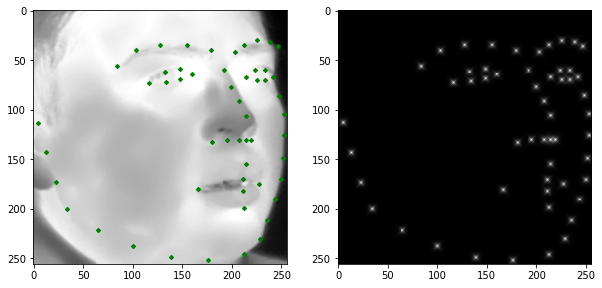

In [11]:
i = 42
visualize(img_train[i], l_train[i], bmask_train[i])

### Loading RWTH-Aachen dataset (additional test set)

In [12]:
# paths to the dataset
jsonFolder = "ThermalFaceDatabase/"
jsonPaths = list(paths.list_files(jsonFolder, validExts="ljson"))
jsonPaths = sorted(jsonPaths)

# original image size
H = 768
W = 1024

# list to store read information
l_aachen = []
img_aachen = []

In [13]:
# loop over the json files
for ind, jsonPath in enumerate(jsonPaths, 1):
    
    print("[INFO] Processing {} file ({}/{})".format(jsonPath.split("/")[-1], ind, len(jsonPaths)))
    
    # opening the json file 
    f = open(jsonPath,) 
  
    # returns the json object as a dictionary 
    data = json.load(f) 

    # extracting filename
    filename = jsonPath.split("/")[-1]
    filename = filename.split(".ljson")[0]
    filename_img = os.path.join(jsonFolder, "{}.png".format(filename))

    # subject id
    subj = int(filename.split('sub0')[1].split('_')[0])
    
    # reading images
    image = cv2.imread(filename_img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # reading landmarks
    land = np.array(data['landmarks']['points'])
    
    # extracting bounding box by padding landmarks
    ys = int(np.min(land[:,0]))-40 
    ye = int(np.max(land[:,0]))+5 
    xs = int(np.min(land[:,1]))-5 
    xe = int(np.max(land[:,1]))+5
    
    # normalize landmarks
    land[:,0] = (land[:,0] - ys) / (ye - ys)
    land[:,1] = (land[:,1] - xs) / (xe - xs)
    
    # downsample landmarks
    landmarks = np.zeros((54, 2)) 
    landmarks[:49,:] = land[:49,:] 
    landmarks[49,:] = land[51,:] 
    landmarks[50,:] = land[54,:] 
    landmarks[51,:] = land[57,:] 
    landmarks[52,:] = land[62,:] 
    landmarks[53,:] = land[66,:]
    
    landmarks = landmarks.flatten()
    
    # crop image to bounding box, resize, normalize
    crop_image = image[ys:ye+1, xs:xe+1]
    crop_image = cv2.resize(crop_image, (w, h) )
    crop_image = crop_image.astype('float32')
    crop_image = crop_image / 255.0  
    
    img_aachen.append(crop_image)    
    l_aachen.append(landmarks)
    
    # closing file 
    f.close()

[INFO] Processing irface_sub001_seq02_frm00006.jpg_lfb.ljson file (1/2935)
[INFO] Processing irface_sub001_seq02_frm00055.jpg_lfb.ljson file (2/2935)
[INFO] Processing irface_sub001_seq02_frm00104.jpg_lfb.ljson file (3/2935)
[INFO] Processing irface_sub001_seq02_frm00155.jpg_lfb.ljson file (4/2935)
[INFO] Processing irface_sub001_seq02_frm00201.jpg_lfb.ljson file (5/2935)
[INFO] Processing irface_sub001_seq02_frm00231.jpg_lfb.ljson file (6/2935)
[INFO] Processing irface_sub001_seq02_frm00268.jpg_lfb.ljson file (7/2935)
[INFO] Processing irface_sub001_seq02_frm00286.jpg_lfb.ljson file (8/2935)
[INFO] Processing irface_sub001_seq02_frm00293.jpg_lfb.ljson file (9/2935)
[INFO] Processing irface_sub001_seq02_frm00303.jpg_lfb.ljson file (10/2935)
[INFO] Processing irface_sub001_seq02_frm00316.jpg_lfb.ljson file (11/2935)
[INFO] Processing irface_sub001_seq02_frm00336.jpg_lfb.ljson file (12/2935)
[INFO] Processing irface_sub001_seq02_frm00349.jpg_lfb.ljson file (13/2935)
[INFO] Processing irf

[INFO] Processing irface_sub003_seq07_frm01662.jpg_lfb.ljson file (142/2935)
[INFO] Processing irface_sub003_seq07_frm02188.jpg_lfb.ljson file (143/2935)
[INFO] Processing irface_sub003_seq07_frm02217.jpg_lfb.ljson file (144/2935)
[INFO] Processing irface_sub003_seq07_frm02245.jpg_lfb.ljson file (145/2935)
[INFO] Processing irface_sub003_seq07_frm02402.jpg_lfb.ljson file (146/2935)
[INFO] Processing irface_sub003_seq07_frm02488.jpg_lfb.ljson file (147/2935)
[INFO] Processing irface_sub003_seq07_frm02573.jpg_lfb.ljson file (148/2935)
[INFO] Processing irface_sub004_seq02_frm00080.jpg_lfb.ljson file (149/2935)
[INFO] Processing irface_sub004_seq02_frm00116.jpg_lfb.ljson file (150/2935)
[INFO] Processing irface_sub004_seq02_frm00153.jpg_lfb.ljson file (151/2935)
[INFO] Processing irface_sub004_seq02_frm00263.jpg_lfb.ljson file (152/2935)
[INFO] Processing irface_sub004_seq02_frm00269.jpg_lfb.ljson file (153/2935)
[INFO] Processing irface_sub004_seq02_frm00278.jpg_lfb.ljson file (154/2935)

[INFO] Processing irface_sub008_seq02_frm00303.jpg_lfb.ljson file (274/2935)
[INFO] Processing irface_sub008_seq02_frm00311.jpg_lfb.ljson file (275/2935)
[INFO] Processing irface_sub008_seq02_frm00317.jpg_lfb.ljson file (276/2935)
[INFO] Processing irface_sub008_seq02_frm00325.jpg_lfb.ljson file (277/2935)
[INFO] Processing irface_sub008_seq02_frm00330.jpg_lfb.ljson file (278/2935)
[INFO] Processing irface_sub008_seq02_frm00340.jpg_lfb.ljson file (279/2935)
[INFO] Processing irface_sub008_seq02_frm00357.jpg_lfb.ljson file (280/2935)
[INFO] Processing irface_sub008_seq02_frm00370.jpg_lfb.ljson file (281/2935)
[INFO] Processing irface_sub008_seq02_frm00379.jpg_lfb.ljson file (282/2935)
[INFO] Processing irface_sub008_seq02_frm00475.jpg_lfb.ljson file (283/2935)
[INFO] Processing irface_sub008_seq02_frm00501.jpg_lfb.ljson file (284/2935)
[INFO] Processing irface_sub008_seq02_frm00525.jpg_lfb.ljson file (285/2935)
[INFO] Processing irface_sub009_seq02_frm00117.jpg_lfb.ljson file (286/2935)

[INFO] Processing irface_sub012_seq03_frm00023.jpg_lfb.ljson file (414/2935)
[INFO] Processing irface_sub012_seq03_frm00192.jpg_lfb.ljson file (415/2935)
[INFO] Processing irface_sub012_seq03_frm00224.jpg_lfb.ljson file (416/2935)
[INFO] Processing irface_sub012_seq03_frm00555.jpg_lfb.ljson file (417/2935)
[INFO] Processing irface_sub012_seq03_frm00604.jpg_lfb.ljson file (418/2935)
[INFO] Processing irface_sub012_seq03_frm00651.jpg_lfb.ljson file (419/2935)
[INFO] Processing irface_sub013_seq02_frm00060.jpg_lfb.ljson file (420/2935)
[INFO] Processing irface_sub013_seq02_frm00087.jpg_lfb.ljson file (421/2935)
[INFO] Processing irface_sub013_seq02_frm00122.jpg_lfb.ljson file (422/2935)
[INFO] Processing irface_sub013_seq02_frm00195.jpg_lfb.ljson file (423/2935)
[INFO] Processing irface_sub013_seq02_frm00200.jpg_lfb.ljson file (424/2935)
[INFO] Processing irface_sub013_seq02_frm00204.jpg_lfb.ljson file (425/2935)
[INFO] Processing irface_sub013_seq02_frm00210.jpg_lfb.ljson file (426/2935)

[INFO] Processing irface_sub015_seq07_frm00322.jpg_lfb.ljson file (549/2935)
[INFO] Processing irface_sub015_seq07_frm00422.jpg_lfb.ljson file (550/2935)
[INFO] Processing irface_sub015_seq07_frm00461.jpg_lfb.ljson file (551/2935)
[INFO] Processing irface_sub015_seq07_frm00499.jpg_lfb.ljson file (552/2935)
[INFO] Processing irface_sub015_seq07_frm00608.jpg_lfb.ljson file (553/2935)
[INFO] Processing irface_sub015_seq07_frm00640.jpg_lfb.ljson file (554/2935)
[INFO] Processing irface_sub015_seq07_frm00672.jpg_lfb.ljson file (555/2935)
[INFO] Processing irface_sub015_seq07_frm00834.jpg_lfb.ljson file (556/2935)
[INFO] Processing irface_sub015_seq07_frm00862.jpg_lfb.ljson file (557/2935)
[INFO] Processing irface_sub015_seq07_frm00889.jpg_lfb.ljson file (558/2935)
[INFO] Processing irface_sub015_seq07_frm01031.jpg_lfb.ljson file (559/2935)
[INFO] Processing irface_sub015_seq07_frm01082.jpg_lfb.ljson file (560/2935)
[INFO] Processing irface_sub015_seq07_frm01133.jpg_lfb.ljson file (561/2935)

[INFO] Processing irface_sub018_seq06_frm01188.png_lfb.ljson file (686/2935)
[INFO] Processing irface_sub018_seq06_frm01412.png_lfb.ljson file (687/2935)
[INFO] Processing irface_sub018_seq06_frm01654.png_lfb.ljson file (688/2935)
[INFO] Processing irface_sub018_seq06_frm01972.png_lfb.ljson file (689/2935)
[INFO] Processing irface_sub018_seq07_frm00001.jpg_lfb.ljson file (690/2935)
[INFO] Processing irface_sub018_seq07_frm00175.jpg_lfb.ljson file (691/2935)
[INFO] Processing irface_sub018_seq07_frm00349.jpg_lfb.ljson file (692/2935)
[INFO] Processing irface_sub018_seq07_frm00409.jpg_lfb.ljson file (693/2935)
[INFO] Processing irface_sub018_seq07_frm00436.jpg_lfb.ljson file (694/2935)
[INFO] Processing irface_sub018_seq07_frm00462.jpg_lfb.ljson file (695/2935)
[INFO] Processing irface_sub018_seq07_frm00567.jpg_lfb.ljson file (696/2935)
[INFO] Processing irface_sub018_seq07_frm00596.jpg_lfb.ljson file (697/2935)
[INFO] Processing irface_sub018_seq07_frm00625.jpg_lfb.ljson file (698/2935)

[INFO] Processing irface_sub022_seq07_frm01990.jpg_lfb.ljson file (824/2935)
[INFO] Processing irface_sub022_seq07_frm02008.jpg_lfb.ljson file (825/2935)
[INFO] Processing irface_sub022_seq07_frm02248.jpg_lfb.ljson file (826/2935)
[INFO] Processing irface_sub022_seq07_frm02266.jpg_lfb.ljson file (827/2935)
[INFO] Processing irface_sub022_seq07_frm02283.jpg_lfb.ljson file (828/2935)
[INFO] Processing irface_sub023_seq02_frm00068.jpg_lfb.ljson file (829/2935)
[INFO] Processing irface_sub023_seq02_frm00099.jpg_lfb.ljson file (830/2935)
[INFO] Processing irface_sub023_seq02_frm00128.jpg_lfb.ljson file (831/2935)
[INFO] Processing irface_sub023_seq02_frm00269.jpg_lfb.ljson file (832/2935)
[INFO] Processing irface_sub023_seq02_frm00277.jpg_lfb.ljson file (833/2935)
[INFO] Processing irface_sub023_seq02_frm00291.jpg_lfb.ljson file (834/2935)
[INFO] Processing irface_sub023_seq02_frm00307.jpg_lfb.ljson file (835/2935)
[INFO] Processing irface_sub023_seq02_frm00318.jpg_lfb.ljson file (836/2935)

[INFO] Processing irface_sub026_seq02_frm00190.jpg_lfb.ljson file (958/2935)
[INFO] Processing irface_sub026_seq02_frm00196.jpg_lfb.ljson file (959/2935)
[INFO] Processing irface_sub026_seq02_frm00202.jpg_lfb.ljson file (960/2935)
[INFO] Processing irface_sub026_seq02_frm00217.jpg_lfb.ljson file (961/2935)
[INFO] Processing irface_sub026_seq02_frm00230.jpg_lfb.ljson file (962/2935)
[INFO] Processing irface_sub026_seq02_frm00239.jpg_lfb.ljson file (963/2935)
[INFO] Processing irface_sub026_seq02_frm00263.jpg_lfb.ljson file (964/2935)
[INFO] Processing irface_sub026_seq02_frm00273.jpg_lfb.ljson file (965/2935)
[INFO] Processing irface_sub026_seq02_frm00284.jpg_lfb.ljson file (966/2935)
[INFO] Processing irface_sub026_seq02_frm00449.jpg_lfb.ljson file (967/2935)
[INFO] Processing irface_sub026_seq02_frm00476.jpg_lfb.ljson file (968/2935)
[INFO] Processing irface_sub026_seq02_frm00523.jpg_lfb.ljson file (969/2935)
[INFO] Processing irface_sub026_seq03_frm00098.jpg_lfb.ljson file (970/2935)

[INFO] Processing irface_sub029_seq02_frm00371.jpg_lfb.ljson file (1068/2935)
[INFO] Processing irface_sub029_seq02_frm00379.jpg_lfb.ljson file (1069/2935)
[INFO] Processing irface_sub029_seq02_frm00390.jpg_lfb.ljson file (1070/2935)
[INFO] Processing irface_sub029_seq02_frm00406.jpg_lfb.ljson file (1071/2935)
[INFO] Processing irface_sub029_seq02_frm00415.jpg_lfb.ljson file (1072/2935)
[INFO] Processing irface_sub029_seq02_frm00429.jpg_lfb.ljson file (1073/2935)
[INFO] Processing irface_sub029_seq02_frm00456.jpg_lfb.ljson file (1074/2935)
[INFO] Processing irface_sub029_seq02_frm00463.jpg_lfb.ljson file (1075/2935)
[INFO] Processing irface_sub029_seq02_frm00472.jpg_lfb.ljson file (1076/2935)
[INFO] Processing irface_sub029_seq02_frm00636.jpg_lfb.ljson file (1077/2935)
[INFO] Processing irface_sub029_seq02_frm00661.jpg_lfb.ljson file (1078/2935)
[INFO] Processing irface_sub029_seq02_frm00685.jpg_lfb.ljson file (1079/2935)
[INFO] Processing irface_sub029_seq03_frm00040.jpg_lfb.ljson fil

[INFO] Processing irface_sub031_seq03_frm00885.jpg_lfb.ljson file (1175/2935)
[INFO] Processing irface_sub031_seq03_frm00985.jpg_lfb.ljson file (1176/2935)
[INFO] Processing irface_sub031_seq07_frm00127.jpg_lfb.ljson file (1177/2935)
[INFO] Processing irface_sub031_seq07_frm00151.jpg_lfb.ljson file (1178/2935)
[INFO] Processing irface_sub031_seq07_frm00175.jpg_lfb.ljson file (1179/2935)
[INFO] Processing irface_sub031_seq07_frm00578.jpg_lfb.ljson file (1180/2935)
[INFO] Processing irface_sub031_seq07_frm00782.jpg_lfb.ljson file (1181/2935)
[INFO] Processing irface_sub031_seq07_frm00986.jpg_lfb.ljson file (1182/2935)
[INFO] Processing irface_sub031_seq07_frm01122.jpg_lfb.ljson file (1183/2935)
[INFO] Processing irface_sub031_seq07_frm01140.jpg_lfb.ljson file (1184/2935)
[INFO] Processing irface_sub031_seq07_frm01158.jpg_lfb.ljson file (1185/2935)
[INFO] Processing irface_sub031_seq07_frm01443.jpg_lfb.ljson file (1186/2935)
[INFO] Processing irface_sub031_seq07_frm01535.jpg_lfb.ljson fil

[INFO] Processing irface_sub034_seq07_frm01039.jpg_lfb.ljson file (1308/2935)
[INFO] Processing irface_sub034_seq07_frm01300.jpg_lfb.ljson file (1309/2935)
[INFO] Processing irface_sub034_seq07_frm01312.jpg_lfb.ljson file (1310/2935)
[INFO] Processing irface_sub034_seq07_frm01323.jpg_lfb.ljson file (1311/2935)
[INFO] Processing irface_sub034_seq07_frm01600.jpg_lfb.ljson file (1312/2935)
[INFO] Processing irface_sub034_seq07_frm01660.jpg_lfb.ljson file (1313/2935)
[INFO] Processing irface_sub034_seq07_frm01720.jpg_lfb.ljson file (1314/2935)
[INFO] Processing irface_sub034_seq07_frm01874.jpg_lfb.ljson file (1315/2935)
[INFO] Processing irface_sub034_seq07_frm01921.jpg_lfb.ljson file (1316/2935)
[INFO] Processing irface_sub034_seq07_frm01967.jpg_lfb.ljson file (1317/2935)
[INFO] Processing irface_sub034_seq07_frm02088.jpg_lfb.ljson file (1318/2935)
[INFO] Processing irface_sub034_seq07_frm02176.jpg_lfb.ljson file (1319/2935)
[INFO] Processing irface_sub034_seq07_frm02263.jpg_lfb.ljson fil

[INFO] Processing irface_sub037_seq07_frm00857.jpg_lfb.ljson file (1445/2935)
[INFO] Processing irface_sub037_seq07_frm00895.jpg_lfb.ljson file (1446/2935)
[INFO] Processing irface_sub037_seq07_frm01053.jpg_lfb.ljson file (1447/2935)
[INFO] Processing irface_sub037_seq07_frm01085.jpg_lfb.ljson file (1448/2935)
[INFO] Processing irface_sub037_seq07_frm01117.jpg_lfb.ljson file (1449/2935)
[INFO] Processing irface_sub037_seq07_frm01295.jpg_lfb.ljson file (1450/2935)
[INFO] Processing irface_sub037_seq07_frm01320.jpg_lfb.ljson file (1451/2935)
[INFO] Processing irface_sub037_seq07_frm01345.jpg_lfb.ljson file (1452/2935)
[INFO] Processing irface_sub037_seq07_frm01542.jpg_lfb.ljson file (1453/2935)
[INFO] Processing irface_sub037_seq07_frm01566.jpg_lfb.ljson file (1454/2935)
[INFO] Processing irface_sub037_seq07_frm01589.jpg_lfb.ljson file (1455/2935)
[INFO] Processing irface_sub038_seq07_frm00010.jpg_lfb.ljson file (1456/2935)
[INFO] Processing irface_sub038_seq07_frm00032.jpg_lfb.ljson fil

[INFO] Processing irface_sub042_seq07_frm01070.jpg_lfb.ljson file (1576/2935)
[INFO] Processing irface_sub042_seq07_frm01093.jpg_lfb.ljson file (1577/2935)
[INFO] Processing irface_sub042_seq07_frm01422.jpg_lfb.ljson file (1578/2935)
[INFO] Processing irface_sub042_seq07_frm01437.jpg_lfb.ljson file (1579/2935)
[INFO] Processing irface_sub042_seq07_frm01451.jpg_lfb.ljson file (1580/2935)
[INFO] Processing irface_sub042_seq07_frm01612.jpg_lfb.ljson file (1581/2935)
[INFO] Processing irface_sub042_seq07_frm01643.jpg_lfb.ljson file (1582/2935)
[INFO] Processing irface_sub042_seq07_frm01673.jpg_lfb.ljson file (1583/2935)
[INFO] Processing irface_sub042_seq07_frm01816.jpg_lfb.ljson file (1584/2935)
[INFO] Processing irface_sub042_seq07_frm01881.jpg_lfb.ljson file (1585/2935)
[INFO] Processing irface_sub042_seq07_frm01945.jpg_lfb.ljson file (1586/2935)
[INFO] Processing irface_sub043_seq07_frm00001.jpg_lfb.ljson file (1587/2935)
[INFO] Processing irface_sub043_seq07_frm00161.jpg_lfb.ljson fil

[INFO] Processing irface_sub048_seq07_frm01711.jpg_lfb.ljson file (1712/2935)
[INFO] Processing irface_sub048_seq07_frm01717.jpg_lfb.ljson file (1713/2935)
[INFO] Processing irface_sub048_seq07_frm01722.jpg_lfb.ljson file (1714/2935)
[INFO] Processing irface_sub048_seq07_frm01955.jpg_lfb.ljson file (1715/2935)
[INFO] Processing irface_sub048_seq07_frm01999.jpg_lfb.ljson file (1716/2935)
[INFO] Processing irface_sub048_seq07_frm02043.jpg_lfb.ljson file (1717/2935)
[INFO] Processing irface_sub050_seq06_frm00403.png_lfb.ljson file (1718/2935)
[INFO] Processing irface_sub050_seq06_frm00536.png_lfb.ljson file (1719/2935)
[INFO] Processing irface_sub050_seq06_frm00656.png_lfb.ljson file (1720/2935)
[INFO] Processing irface_sub050_seq06_frm00762.png_lfb.ljson file (1721/2935)
[INFO] Processing irface_sub050_seq06_frm00892.png_lfb.ljson file (1722/2935)
[INFO] Processing irface_sub050_seq06_frm01003.png_lfb.ljson file (1723/2935)
[INFO] Processing irface_sub050_seq06_frm01204.png_lfb.ljson fil

[INFO] Processing irface_sub054_seq06_frm00924.png_lfb.ljson file (1845/2935)
[INFO] Processing irface_sub054_seq06_frm01093.png_lfb.ljson file (1846/2935)
[INFO] Processing irface_sub054_seq06_frm01260.png_lfb.ljson file (1847/2935)
[INFO] Processing irface_sub054_seq06_frm01380.png_lfb.ljson file (1848/2935)
[INFO] Processing irface_sub054_seq07_frm00001.jpg_lfb.ljson file (1849/2935)
[INFO] Processing irface_sub054_seq07_frm00160.jpg_lfb.ljson file (1850/2935)
[INFO] Processing irface_sub054_seq07_frm00318.jpg_lfb.ljson file (1851/2935)
[INFO] Processing irface_sub054_seq07_frm00421.jpg_lfb.ljson file (1852/2935)
[INFO] Processing irface_sub054_seq07_frm00459.jpg_lfb.ljson file (1853/2935)
[INFO] Processing irface_sub054_seq07_frm00496.jpg_lfb.ljson file (1854/2935)
[INFO] Processing irface_sub054_seq07_frm00586.jpg_lfb.ljson file (1855/2935)
[INFO] Processing irface_sub054_seq07_frm00647.jpg_lfb.ljson file (1856/2935)
[INFO] Processing irface_sub054_seq07_frm00707.jpg_lfb.ljson fil

[INFO] Processing irface_sub061_seq06_frm00461.png_lfb.ljson file (1986/2935)
[INFO] Processing irface_sub061_seq06_frm00626.png_lfb.ljson file (1987/2935)
[INFO] Processing irface_sub061_seq06_frm00828.png_lfb.ljson file (1988/2935)
[INFO] Processing irface_sub061_seq06_frm01081.png_lfb.ljson file (1989/2935)
[INFO] Processing irface_sub061_seq06_frm01228.png_lfb.ljson file (1990/2935)
[INFO] Processing irface_sub061_seq06_frm01358.png_lfb.ljson file (1991/2935)
[INFO] Processing irface_sub061_seq07_frm00001.jpg_lfb.ljson file (1992/2935)
[INFO] Processing irface_sub061_seq07_frm00166.jpg_lfb.ljson file (1993/2935)
[INFO] Processing irface_sub061_seq07_frm00331.jpg_lfb.ljson file (1994/2935)
[INFO] Processing irface_sub061_seq07_frm00436.jpg_lfb.ljson file (1995/2935)
[INFO] Processing irface_sub061_seq07_frm00465.jpg_lfb.ljson file (1996/2935)
[INFO] Processing irface_sub061_seq07_frm00493.jpg_lfb.ljson file (1997/2935)
[INFO] Processing irface_sub061_seq07_frm00603.jpg_lfb.ljson fil

[INFO] Processing irface_sub065_seq07_frm00995.jpg_lfb.ljson file (2116/2935)
[INFO] Processing irface_sub065_seq07_frm01112.jpg_lfb.ljson file (2117/2935)
[INFO] Processing irface_sub065_seq07_frm01133.jpg_lfb.ljson file (2118/2935)
[INFO] Processing irface_sub065_seq07_frm01154.jpg_lfb.ljson file (2119/2935)
[INFO] Processing irface_sub065_seq07_frm01263.jpg_lfb.ljson file (2120/2935)
[INFO] Processing irface_sub065_seq07_frm01298.jpg_lfb.ljson file (2121/2935)
[INFO] Processing irface_sub065_seq07_frm01333.jpg_lfb.ljson file (2122/2935)
[INFO] Processing irface_sub066_seq06_frm00519.png_lfb.ljson file (2123/2935)
[INFO] Processing irface_sub066_seq06_frm00649.png_lfb.ljson file (2124/2935)
[INFO] Processing irface_sub066_seq06_frm00747.png_lfb.ljson file (2125/2935)
[INFO] Processing irface_sub066_seq06_frm00921.png_lfb.ljson file (2126/2935)
[INFO] Processing irface_sub066_seq06_frm01092.png_lfb.ljson file (2127/2935)
[INFO] Processing irface_sub066_seq06_frm01237.png_lfb.ljson fil

[INFO] Processing irface_sub070_seq07_frm00579.jpg_lfb.ljson file (2249/2935)
[INFO] Processing irface_sub070_seq07_frm00686.jpg_lfb.ljson file (2250/2935)
[INFO] Processing irface_sub070_seq07_frm00688.jpg_lfb.ljson file (2251/2935)
[INFO] Processing irface_sub070_seq07_frm00690.jpg_lfb.ljson file (2252/2935)
[INFO] Processing irface_sub070_seq07_frm00879.jpg_lfb.ljson file (2253/2935)
[INFO] Processing irface_sub070_seq07_frm00893.jpg_lfb.ljson file (2254/2935)
[INFO] Processing irface_sub070_seq07_frm00906.jpg_lfb.ljson file (2255/2935)
[INFO] Processing irface_sub070_seq07_frm01028.jpg_lfb.ljson file (2256/2935)
[INFO] Processing irface_sub070_seq07_frm01037.jpg_lfb.ljson file (2257/2935)
[INFO] Processing irface_sub070_seq07_frm01046.jpg_lfb.ljson file (2258/2935)
[INFO] Processing irface_sub070_seq07_frm01201.jpg_lfb.ljson file (2259/2935)
[INFO] Processing irface_sub070_seq07_frm01236.jpg_lfb.ljson file (2260/2935)
[INFO] Processing irface_sub070_seq07_frm01270.jpg_lfb.ljson fil

[INFO] Processing irface_sub075_seq07_frm00039.jpg_lfb.ljson file (2383/2935)
[INFO] Processing irface_sub075_seq07_frm00142.jpg_lfb.ljson file (2384/2935)
[INFO] Processing irface_sub075_seq07_frm00245.jpg_lfb.ljson file (2385/2935)
[INFO] Processing irface_sub075_seq07_frm00312.jpg_lfb.ljson file (2386/2935)
[INFO] Processing irface_sub075_seq07_frm00345.jpg_lfb.ljson file (2387/2935)
[INFO] Processing irface_sub075_seq07_frm00378.jpg_lfb.ljson file (2388/2935)
[INFO] Processing irface_sub075_seq07_frm00509.jpg_lfb.ljson file (2389/2935)
[INFO] Processing irface_sub075_seq07_frm00564.jpg_lfb.ljson file (2390/2935)
[INFO] Processing irface_sub075_seq07_frm00619.jpg_lfb.ljson file (2391/2935)
[INFO] Processing irface_sub075_seq07_frm00698.jpg_lfb.ljson file (2392/2935)
[INFO] Processing irface_sub075_seq07_frm00706.jpg_lfb.ljson file (2393/2935)
[INFO] Processing irface_sub075_seq07_frm00714.jpg_lfb.ljson file (2394/2935)
[INFO] Processing irface_sub075_seq07_frm01305.jpg_lfb.ljson fil

[INFO] Processing irface_sub080_seq07_frm00026.jpg_lfb.ljson file (2515/2935)
[INFO] Processing irface_sub080_seq07_frm00155.jpg_lfb.ljson file (2516/2935)
[INFO] Processing irface_sub080_seq07_frm00284.jpg_lfb.ljson file (2517/2935)
[INFO] Processing irface_sub080_seq07_frm00380.jpg_lfb.ljson file (2518/2935)
[INFO] Processing irface_sub080_seq07_frm00392.jpg_lfb.ljson file (2519/2935)
[INFO] Processing irface_sub080_seq07_frm00404.jpg_lfb.ljson file (2520/2935)
[INFO] Processing irface_sub080_seq07_frm00496.jpg_lfb.ljson file (2521/2935)
[INFO] Processing irface_sub080_seq07_frm00525.jpg_lfb.ljson file (2522/2935)
[INFO] Processing irface_sub080_seq07_frm00554.jpg_lfb.ljson file (2523/2935)
[INFO] Processing irface_sub080_seq07_frm00625.jpg_lfb.ljson file (2524/2935)
[INFO] Processing irface_sub080_seq07_frm00633.jpg_lfb.ljson file (2525/2935)
[INFO] Processing irface_sub080_seq07_frm00640.jpg_lfb.ljson file (2526/2935)
[INFO] Processing irface_sub080_seq07_frm00755.jpg_lfb.ljson fil

[INFO] Processing irface_sub085_seq07_frm01118.jpg_lfb.ljson file (2650/2935)
[INFO] Processing irface_sub085_seq07_frm01164.jpg_lfb.ljson file (2651/2935)
[INFO] Processing irface_sub085_seq07_frm01209.jpg_lfb.ljson file (2652/2935)
[INFO] Processing irface_sub085_seq07_frm01746.jpg_lfb.ljson file (2653/2935)
[INFO] Processing irface_sub085_seq07_frm01759.jpg_lfb.ljson file (2654/2935)
[INFO] Processing irface_sub085_seq07_frm01771.jpg_lfb.ljson file (2655/2935)
[INFO] Processing irface_sub085_seq07_frm02466.jpg_lfb.ljson file (2656/2935)
[INFO] Processing irface_sub085_seq07_frm02471.jpg_lfb.ljson file (2657/2935)
[INFO] Processing irface_sub085_seq07_frm02476.jpg_lfb.ljson file (2658/2935)
[INFO] Processing irface_sub085_seq07_frm02772.jpg_lfb.ljson file (2659/2935)
[INFO] Processing irface_sub085_seq07_frm02810.jpg_lfb.ljson file (2660/2935)
[INFO] Processing irface_sub085_seq07_frm02848.jpg_lfb.ljson file (2661/2935)
[INFO] Processing irface_sub086_seq06_frm00430.jpg_lfb.ljson fil

[INFO] Processing irface_sub090_seq06_frm00857.png_lfb.ljson file (2784/2935)
[INFO] Processing irface_sub090_seq06_frm00988.png_lfb.ljson file (2785/2935)
[INFO] Processing irface_sub090_seq06_frm01113.png_lfb.ljson file (2786/2935)
[INFO] Processing irface_sub090_seq06_frm01229.png_lfb.ljson file (2787/2935)
[INFO] Processing irface_sub090_seq07_frm00001.jpg_lfb.ljson file (2788/2935)
[INFO] Processing irface_sub090_seq07_frm00154.jpg_lfb.ljson file (2789/2935)
[INFO] Processing irface_sub090_seq07_frm00307.jpg_lfb.ljson file (2790/2935)
[INFO] Processing irface_sub090_seq07_frm00354.jpg_lfb.ljson file (2791/2935)
[INFO] Processing irface_sub090_seq07_frm00382.jpg_lfb.ljson file (2792/2935)
[INFO] Processing irface_sub090_seq07_frm00410.jpg_lfb.ljson file (2793/2935)
[INFO] Processing irface_sub090_seq07_frm00475.jpg_lfb.ljson file (2794/2935)
[INFO] Processing irface_sub090_seq07_frm00533.jpg_lfb.ljson file (2795/2935)
[INFO] Processing irface_sub090_seq07_frm00590.jpg_lfb.ljson fil

[INFO] Processing irface_sub094_seq07_frm00388.jpg_lfb.ljson file (2916/2935)
[INFO] Processing irface_sub094_seq07_frm00412.jpg_lfb.ljson file (2917/2935)
[INFO] Processing irface_sub094_seq07_frm00536.jpg_lfb.ljson file (2918/2935)
[INFO] Processing irface_sub094_seq07_frm00596.jpg_lfb.ljson file (2919/2935)
[INFO] Processing irface_sub094_seq07_frm00656.jpg_lfb.ljson file (2920/2935)
[INFO] Processing irface_sub094_seq07_frm00755.jpg_lfb.ljson file (2921/2935)
[INFO] Processing irface_sub094_seq07_frm00775.jpg_lfb.ljson file (2922/2935)
[INFO] Processing irface_sub094_seq07_frm00795.jpg_lfb.ljson file (2923/2935)
[INFO] Processing irface_sub094_seq07_frm01005.jpg_lfb.ljson file (2924/2935)
[INFO] Processing irface_sub094_seq07_frm01048.jpg_lfb.ljson file (2925/2935)
[INFO] Processing irface_sub094_seq07_frm01091.jpg_lfb.ljson file (2926/2935)
[INFO] Processing irface_sub094_seq07_frm01221.jpg_lfb.ljson file (2927/2935)
[INFO] Processing irface_sub094_seq07_frm01264.jpg_lfb.ljson fil

In [14]:
# expand dimensions so that images have one channel
img_aachen = np.expand_dims(np.array(img_aachen), axis = 3)
l_aachen = np.array(l_aachen)

# sanity check
print(img_aachen.shape)
print(l_aachen.shape)

(2935, 256, 256, 1)
(2935, 108)


### Model

In [15]:
input_size = (h, w, 1)
inputs = keras.Input(input_size)

# downsampling

conv1 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv1)

pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv2)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv3)

pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv4)

pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(1024, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv5)

drop5 = Dropout(0.5)(conv5)

# upsampling

up6 = Conv2DTranspose(512, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (drop5)
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv6)

up7 = Conv2DTranspose(256, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (conv6)
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv7)

up8 = Conv2DTranspose(128, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (conv7)
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv8)

up9 = Conv2DTranspose(64, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (conv8)
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv9)

drop9 = Dropout(0.5)(conv9)

conv10 = Conv2D(1, 1, activation = 'sigmoid', padding = 'same', kernel_initializer='glorot_normal')(drop9)

u_net = keras.Model(inputs = inputs, outputs = conv10)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
u_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### First Stage: Pre-Training

In [17]:
# create checkpoint
checkpoint_dir = "checkpoints-sf-0-1"
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir+"/landmark", 
                                                      save_weights_only=True, 
                                                      save_best_only=True,monitor='val_loss',
                                                      verbose=1)

# initializing callback function
callbacks0 = [callback_checkpoint]

if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.mkdir(checkpoint_dir)
    print("Checkpoint directory created: {}".format(checkpoint_dir))

# if checkpoint exists, load the weights
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    print("Checkpoint found: {}, restoring...".format(latest_checkpoint))
    u_net.load_weights(latest_checkpoint)
    print("Checkpoint restored: {}".format(latest_checkpoint))
else:
    print("Checkpoint not found. Model weights will be initialized randomly.")

Checkpoint found: checkpoints-sf-0-1/landmark, restoring...
Checkpoint restored: checkpoints-sf-0-1/landmark


In [ ]:
# learning rate scheduler

def lr_schedule( epoch ):

    lr = 5e-4
    
    if epoch >= 10:
        lr = 1e-4

    print("Learning rate: ", lr)
    return lr

In [ ]:
# setting learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# setting early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks0.append(lr_scheduler)
callbacks0.append(es)

In [ ]:
# compile
u_net.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(lr_schedule(0)))

Learning rate:  0.0005
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# train
history = u_net.fit(img_train, bmask_train, validation_data=(img_val, bmask_val), shuffle=True, batch_size=32, epochs=20, callbacks=callbacks0)

Train on 3558 samples, validate on 360 samples
Learning rate:  0.0005
Epoch 1/20
3552/3558 [============================>.] - ETA: 0s - loss: 0.1079
Epoch 00001: val_loss improved from inf to 0.06745, saving model to checkpoints-sf-1-1/landmark
3558/3558 [==============================] - 79s 22ms/sample - loss: 0.1078 - val_loss: 0.0674
Learning rate:  0.0005
Epoch 2/20
3552/3558 [============================>.] - ETA: 0s - loss: 0.0687
Epoch 00002: val_loss improved from 0.06745 to 0.06270, saving model to checkpoints-sf-1-1/landmark
3558/3558 [==============================] - 60s 17ms/sample - loss: 0.0687 - val_loss: 0.0627
Learning rate:  0.0005
Epoch 3/20
3552/3558 [============================>.] - ETA: 0s - loss: 0.0623
Epoch 00003: val_loss improved from 0.06270 to 0.05680, saving model to checkpoints-sf-1-1/landmark
3558/3558 [==============================] - 60s 17ms/sample - loss: 0.0623 - val_loss: 0.0568
Learning rate:  0.0005
Epoch 4/20
3552/3558 [=====================

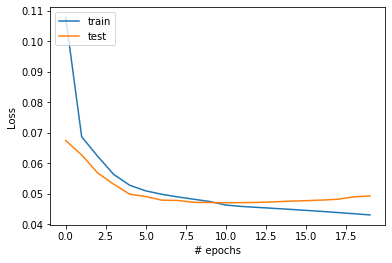

In [ ]:
# plot loss vs epochs curve

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('# epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# visualizing predicted mask
    
def visualize_mask_prediction(ind, images, masks_gt):

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    
    # predict mask on one image
    img = images[ind].copy()
    img = np.expand_dims(img, axis = 0)    
    mask_pr = u_net.predict(img)

    # plot
    axs[0].imshow(img[0, :,:,0], cmap = 'gray')           # image
    axs[1].imshow(masks_gt[ind, :,:,0], cmap = 'gray')    # ground truth mask
    axs[2].imshow(mask_pr[0, :,:,0], cmap = 'gray')       # predicted mask
    
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')

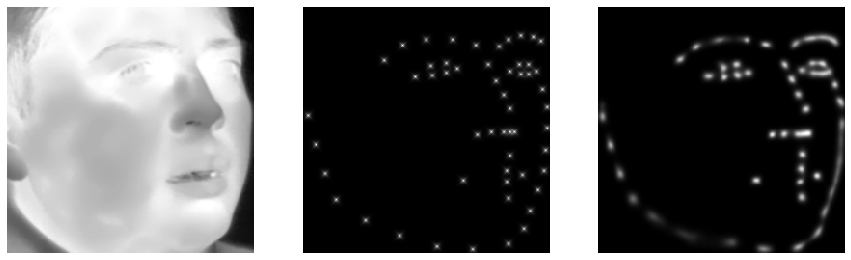

In [19]:
visualize_mask_prediction(42, img_train, bmask_train)

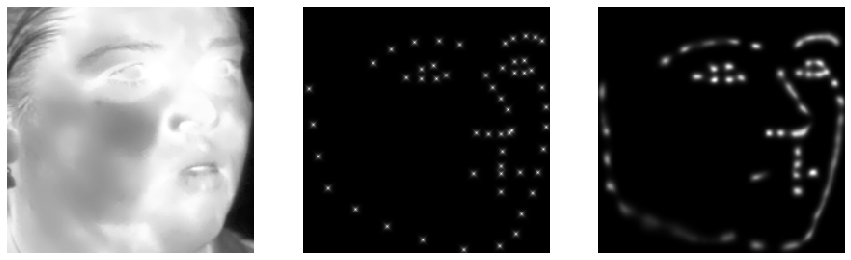

In [20]:
visualize_mask_prediction(42, img_test, bmask_test)

### Second Stage: Pre-Training

In [21]:
# fully connected layers
avg_pooling = AveragePooling2D(pool_size=(7, 7))(u_net.output)
flat = Flatten() (avg_pooling)
fc0 = Dense(2048, activation = 'relu') (flat)
dropout0 = Dropout(0.3)(fc0)
fc1 = Dense(512, activation = 'relu') (dropout0)
dropout1 = Dropout(0.3)(fc1)
fc2  = Dense(108, activation = 'sigmoid') (dropout1)

# define full model
model_full = keras.Model(inputs=u_net.input, outputs=fc2)

# freeze U-net layers
u_net.trainable = False

In [22]:
# to check whether layers are trainable or not

for i,layer in enumerate(model_full.layers):
    print(i,layer.name,layer.trainable)

0 input_1 False
1 conv2d False
2 conv2d_1 False
3 max_pooling2d False
4 conv2d_2 False
5 conv2d_3 False
6 max_pooling2d_1 False
7 conv2d_4 False
8 conv2d_5 False
9 max_pooling2d_2 False
10 conv2d_6 False
11 conv2d_7 False
12 max_pooling2d_3 False
13 conv2d_8 False
14 conv2d_9 False
15 dropout False
16 conv2d_transpose False
17 concatenate False
18 conv2d_10 False
19 conv2d_11 False
20 conv2d_transpose_1 False
21 concatenate_1 False
22 conv2d_12 False
23 conv2d_13 False
24 conv2d_transpose_2 False
25 concatenate_2 False
26 conv2d_14 False
27 conv2d_15 False
28 conv2d_transpose_3 False
29 concatenate_3 False
30 conv2d_16 False
31 conv2d_17 False
32 dropout_1 False
33 conv2d_18 False
34 average_pooling2d True
35 flatten True
36 dense True
37 dropout_2 True
38 dense_1 True
39 dropout_3 True
40 dense_2 True


In [ ]:
# Wing loss

def wing_loss(land_gt, land_pred, w=10.0, epsilon=2.0):

    with tf.name_scope('wing_loss'):
        
        # compute constant C
        C = w * (1.0 - math.log(1.0 + w / epsilon))
        
        x = land_gt - land_pred
        abs_x = tf.abs(x)
        
        # if absolute x is smaller than w, then first equation
        # otherwise, second
        losses = tf.where(tf.greater(w, abs_x), w * tf.math.log(1.0 + abs_x / epsilon), abs_x - C)        
        loss = tf.reduce_mean(losses)
        
        return loss

In [41]:
# create checkpoint
checkpoint_dir = "checkpoints-sf-0-2"

callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir+"/landmark", 
                                                      save_weights_only=True, 
                                                      save_best_only=True,monitor='val_loss',
                                                      verbose=1)

# initializing callback function
callbacks1 = [callback_checkpoint]

if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.mkdir(checkpoint_dir)
    print("Checkpoint directory created: {}".format(checkpoint_dir))
    
# if checkpoint exists, load the weights
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    print("Checkpoint found: {}, restoring...".format(latest_checkpoint))
    u_net.load_weights(latest_checkpoint)
    print("Checkpoint restored: {}".format(latest_checkpoint))
else:
    print("Checkpoint not found. Model weights will be initialized randomly.")


Checkpoint found: checkpoints-sf-0-2/landmark, restoring...
Checkpoint restored: checkpoints-sf-0-2/landmark


In [ ]:
# learning rate scheduler
def lr_schedule( epoch ):

    lr = 1e-3
    
    if epoch >= 20:
        lr = 1e-4

    print("Learning rate: ", lr)
    return lr

In [ ]:
# setting learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# setting early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks1.append(lr_scheduler)
callbacks1.append(es)

In [ ]:
# compile
model_full.compile(optimizer = keras.optimizers.Adam(lr_schedule(0)), loss=wing_loss)

Learning rate:  0.001


In [ ]:
# train
history2 = model_full.fit(img_train, l_train, validation_data=(img_val, l_val), batch_size=16, shuffle=True, epochs=40, callbacks=callbacks1)

Train on 3558 samples, validate on 360 samples
Learning rate:  0.001
Epoch 1/40
3552/3558 [============================>.] - ETA: 0s - loss: 0.2108
Epoch 00001: val_loss improved from inf to 0.11529, saving model to checkpoints-sf-1-2/landmark
3558/3558 [==============================] - 25s 7ms/sample - loss: 0.2107 - val_loss: 0.1153
Learning rate:  0.001
Epoch 2/40
3552/3558 [============================>.] - ETA: 0s - loss: 0.1243
Epoch 00002: val_loss improved from 0.11529 to 0.09211, saving model to checkpoints-sf-1-2/landmark
3558/3558 [==============================] - 23s 6ms/sample - loss: 0.1243 - val_loss: 0.0921
Learning rate:  0.001
Epoch 3/40
3552/3558 [============================>.] - ETA: 0s - loss: 0.1107
Epoch 00003: val_loss improved from 0.09211 to 0.08253, saving model to checkpoints-sf-1-2/landmark
3558/3558 [==============================] - 23s 6ms/sample - loss: 0.1107 - val_loss: 0.0825
Learning rate:  0.001
Epoch 4/40
3552/3558 [============================

3558/3558 [==============================] - 23s 6ms/sample - loss: 0.0669 - val_loss: 0.0552
Learning rate:  0.0001
Epoch 31/40
3552/3558 [============================>.] - ETA: 0s - loss: 0.0666
Epoch 00031: val_loss did not improve from 0.05524
3558/3558 [==============================] - 23s 6ms/sample - loss: 0.0666 - val_loss: 0.0559
Learning rate:  0.0001
Epoch 32/40
3552/3558 [============================>.] - ETA: 0s - loss: 0.0666
Epoch 00032: val_loss did not improve from 0.05524
3558/3558 [==============================] - 23s 6ms/sample - loss: 0.0666 - val_loss: 0.0554
Learning rate:  0.0001
Epoch 33/40
3552/3558 [============================>.] - ETA: 0s - loss: 0.0666
Epoch 00033: val_loss did not improve from 0.05524
3558/3558 [==============================] - 23s 6ms/sample - loss: 0.0666 - val_loss: 0.0556
Learning rate:  0.0001
Epoch 34/40
3552/3558 [============================>.] - ETA: 0s - loss: 0.0662
Epoch 00034: val_loss did not improve from 0.05524
3558/355

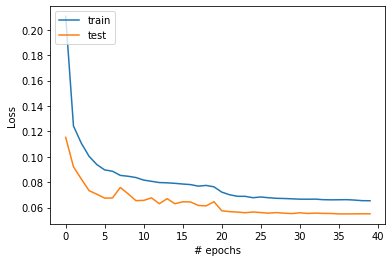

In [ ]:
# plot loss vs epochs curve

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('# epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
# visualize prediction on single image

def visualize_pred(ind, images, landmarks):
    
    plt.figure(figsize=(5,5))
    
    # load an image    
    img = images[ind].copy()
    img = np.expand_dims(img, axis = 0)
    plt.imshow(img[0][:,:,0], cmap='gray')
    
    land_pred = model_full.predict(img)    

    # ground truth landmarks
    keypoints = landmarks[ind].copy().reshape(KEYPOINTS,2)
    keypoints[:,0] = keypoints[:,0] * h
    keypoints[:,1] = keypoints[:,1] * w
    plt.plot(keypoints[:,1], keypoints[:,0], 'go', markersize=3)
    
    # predicted landmarks
    keypointsT = land_pred[0].copy().reshape(KEYPOINTS,2)
    keypointsT[:,0] = keypointsT[:,0] * h
    keypointsT[:,1] = keypointsT[:,1] * w
    plt.plot(keypointsT[:,1], keypointsT[:,0], 'ro', markersize=3)    
    
    plt.axis('off')

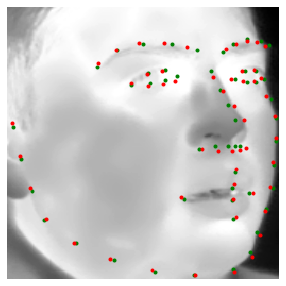

In [42]:
visualize_pred(42, img_train, l_train)

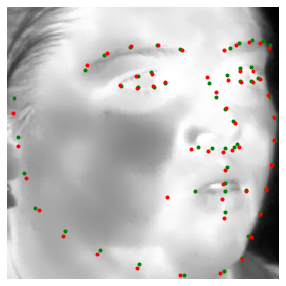

In [43]:
visualize_pred(42, img_test, l_test)

In [27]:
# visualize prediction on random ten images

def visualize_pred_rand(images, landmarks, gt=True):

    fig, axs = plt.subplots(2, 5, figsize=(15,6))    
    plt.subplots_adjust(wspace=0, hspace=0.1)
    
    # selecting 10 random images from set
    indexes = np.random.randint(0,images.shape[0],10)
    img = images[indexes]
    land = landmarks[indexes]
    land_pred = model_full.predict(img)
    
    # iterate over images
    ind = 0
    
    for i in range(2):
        for j in range(5):
            
            # display image
            axs[i, j].imshow(img[ind][:,:,0], cmap='gray')
            
            # display predicted landmarks
            keypointsT = land_pred[ind].copy().reshape(KEYPOINTS,2)
            keypointsT[:,0] = keypointsT[:,0] * h
            keypointsT[:,1] = keypointsT[:,1] * w

            axs[i, j].plot(keypointsT[:,1], keypointsT[:,0], 'ro', markersize=2)
            
            # if gt is true, display ground truth landmarks
            if gt:
                keypoints = land[ind].copy().reshape(KEYPOINTS,2)
                keypoints[:,0] = keypoints[:,0] * h
                keypoints[:,1] = keypoints[:,1] * w           
                axs[i, j].plot(keypoints[:,1], keypoints[:,0], 'go', markersize=2)

            # turn off axis display
            axs[i, j].axis('off')
            
            ind += 1
    
    # save figure
    plt.savefig("results.png")

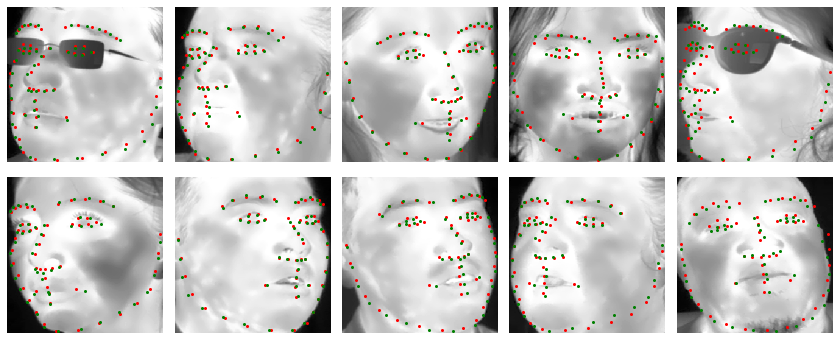

In [44]:
visualize_pred_rand(img_test, l_test)

In [ ]:
# normalized mean error

def NME(land, land_pred):
    
    N = land.shape[0]    
    l = land.reshape(land.shape[:-1] + (KEYPOINTS,2))
    lt = land_pred.reshape(land_pred.shape[:-1] + (KEYPOINTS,2))
    
    # error for one sample
    nme = (np.sum(np.sqrt(np.sum((l - lt)**2, axis=2)), axis=1)
                            / np.sqrt(np.sum((l[:,45] - l[:,36])**2, axis=1))) / KEYPOINTS
        
    # average over the whole sample
    nme_avg = np.sum(nme) / N
    
    return nme_avg

In [ ]:
# predicting landmarks
l_test_pred = model_full.predict(img_test)
l_train_pred = model_full.predict(img_train)
l_val_pred = model_full.predict(img_val)

# evaluating NME of predictions
print("Normalized Mean Error on training set: ", NME(l_train, l_train_pred))
print("Normalized Mean Error on validation set: ", NME(l_val, l_val_pred))
print("Normalized Mean Error on testing set: ", NME(l_test, l_test_pred))

Normalized Mean Error on training set:  0.02796857651584806
Normalized Mean Error on validation set:  0.03330629355270747
Normalized Mean Error on testing set:  0.03562876964076335


### Third Stage: Full Training

In [ ]:
# unfreezing the U-net layers
u_net.trainable = True

for i,layer in enumerate(model_full.layers):
    print(i,layer.name,layer.trainable)

0 input_1 True
1 conv2d True
2 conv2d_1 True
3 max_pooling2d True
4 conv2d_2 True
5 conv2d_3 True
6 max_pooling2d_1 True
7 conv2d_4 True
8 conv2d_5 True
9 max_pooling2d_2 True
10 conv2d_6 True
11 conv2d_7 True
12 max_pooling2d_3 True
13 conv2d_8 True
14 conv2d_9 True
15 dropout True
16 conv2d_transpose True
17 concatenate True
18 conv2d_10 True
19 conv2d_11 True
20 conv2d_transpose_1 True
21 concatenate_1 True
22 conv2d_12 True
23 conv2d_13 True
24 conv2d_transpose_2 True
25 concatenate_2 True
26 conv2d_14 True
27 conv2d_15 True
28 conv2d_transpose_3 True
29 concatenate_3 True
30 conv2d_16 True
31 conv2d_17 True
32 dropout_1 True
33 conv2d_18 True
34 average_pooling2d True
35 flatten True
36 dense True
37 dropout_2 True
38 dense_1 True
39 dropout_3 True
40 dense_2 True


In [35]:
# create checkpoint
checkpoint_dir = "checkpoints-sf-0-3"

callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir+"/landmark", 
                                                      save_weights_only=True, 
                                                      save_best_only=True,monitor='val_loss',
                                                      verbose=1)

# initializing callback function
callbacks2 = [callback_checkpoint]

if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.mkdir(checkpoint_dir)
    print("Checkpoint directory created: {}".format(checkpoint_dir))

# if checkpoint exists, load the weights
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    print("Checkpoint found: {}, restoring...".format(latest_checkpoint))
    model_full.load_weights(latest_checkpoint)
    print("Checkpoint restored: {}".format(latest_checkpoint))
else:
    print("Checkpoint not found. Model weights will be initialized randomly.")

Checkpoint found: checkpoints-sf-0-3/landmark, restoring...
Checkpoint restored: checkpoints-sf-0-3/landmark


In [ ]:
# learning rate scheduler

def lr_schedule( epoch ):

    lr = 1e-4

    print("Learning rate: ", lr)
    return lr

In [ ]:
# setting learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# setting early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks2.append(lr_scheduler)
callbacks2.append(es)

In [ ]:
# compile
model_full.compile(optimizer = keras.optimizers.Adam(lr_schedule(0)), loss=wing_loss)

Learning rate:  0.0001


In [ ]:
# train
history3 = model_full.fit(img_train, l_train, validation_data=(img_val, l_val), batch_size=16, shuffle=True, epochs=20, callbacks=callbacks2)

Train on 3558 samples, validate on 360 samples
Learning rate:  0.0001
Epoch 1/20
3552/3558 [============================>.] - ETA: 0s - loss: 0.0678
Epoch 00001: val_loss improved from inf to 0.05701, saving model to checkpoints-sf-1-3/landmark
3558/3558 [==============================] - 64s 18ms/sample - loss: 0.0678 - val_loss: 0.0570
Learning rate:  0.0001
Epoch 2/20
3552/3558 [============================>.] - ETA: 0s - loss: 0.0683
Epoch 00002: val_loss did not improve from 0.05701
3558/3558 [==============================] - 60s 17ms/sample - loss: 0.0682 - val_loss: 0.0582
Learning rate:  0.0001
Epoch 3/20
3552/3558 [============================>.] - ETA: 0s - loss: 0.0681
Epoch 00003: val_loss improved from 0.05701 to 0.05691, saving model to checkpoints-sf-1-3/landmark
3558/3558 [==============================] - 61s 17ms/sample - loss: 0.0681 - val_loss: 0.0569
Learning rate:  0.0001
Epoch 4/20
3552/3558 [============================>.] - ETA: 0s - loss: 0.0676
Epoch 00004: 

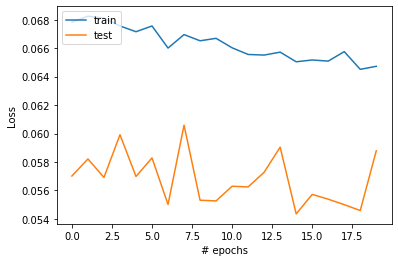

In [ ]:
# plot loss vs epochs curve

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('# epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# load best weights from checkpoint

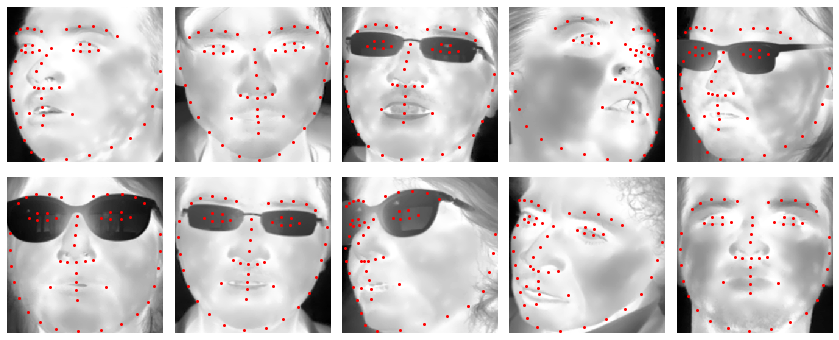

In [36]:
# visualize ten random predictions from test set

visualize_pred_rand(img_test, l_test, False)

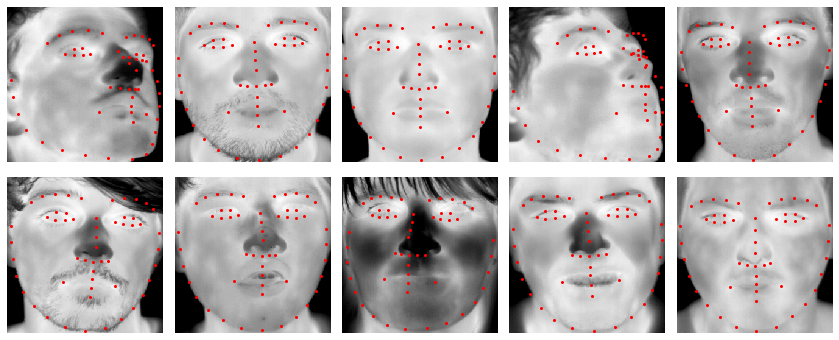

In [37]:
# visualize ten random predictions from RWTH-Aachen set

visualize_pred_rand(img_aachen, l_aachen, False)

In [ ]:
# calculate Mean Absolute Error

def MAE(l, l_pred):
    
    mae = keras.losses.mean_absolute_error(l, l_pred)
    
    return np.mean(tf.Session().run(mae))

In [ ]:
# calculate average time needed to predict landmarks on an image

def inference_speed(images):
    
    timings = []
    
    # iterate over images
    for img in images:
        
        img = np.expand_dims(img, axis = 0)
        
        # record time
        start = time.time()
        preds = model_full.predict(img)
        end = time.time() 

        timings.append(end - start)
    
    return np.average(timings)

In [ ]:
# predicting landmarks
l_train_pred = model_full.predict(img_train)
l_val_pred = model_full.predict(img_val)
l_test_pred = model_full.predict(img_test)
l_test_aa_pred = model_full.predict(img_aachen)

In [ ]:
# evaluating NME of predictions
print("Normalized Mean Error on training set: ", NME(l_train, l_train_pred))
print("Normalized Mean Error on validation set: ", NME(l_val, l_val_pred))
print("Normalized Mean Error on testing set: ", NME(l_test, l_test_pred))
print("Normalized Mean Error on RWTH-Aachen: ", NME(l_aachen, l_test_aa_pred))
      
# evaluating MAE of predictions
print("\nMean Absolute Error on training set: ", MAE(l_train, l_train_pred))
print("Mean Absolute Error on validation set: ", MAE(l_val, l_val_pred))
print("Mean Absolute Error on testing set: ", MAE(l_test, l_test_pred))
print("Mean Absolute Error on RWTH-Aachen: ", MAE(l_aachen, l_test_aa_pred))

Normalized Mean Error on training set:  0.027968576554859997
Normalized Mean Error on validation set:  0.033306293793537625
Normalized Mean Error on testing set:  0.03562876961097509
Normalized Mean Error on RWTH-Aachen:  0.058695503525919825

Mean Absolute Error on training set:  0.009228825
Mean Absolute Error on validation set:  0.0110948
Mean Absolute Error on testing set:  0.011755808
Mean Absolute Error on RWTH-Aachen:  0.022014903


In [ ]:
# inference speed

print("Inference speed (average per image): ", inference_speed(img_test))

Inference speed (average per image):  0.011249885275647357


In [ ]:
# save weights

model_full.save('model.h5')
print("Model size (KB): ", os.path.getsize('model.h5')/1000)

Model size (KB):  153208.304
